**Project Introduction: Predicting Sepsis Risk in ICU Patients**

In this machine learning project, our goal is to develop a predictive model that can help healthcare professionals identify whether a patient in the Intensive Care Unit (ICU) is at risk of developing sepsis. "Sepsis" is a serious medical condition that occurs when the body's response to infection results in a widespread and potentially life-threatening inflammatory response. It is often referred to as "septicemia" or "blood poisoning." Sepsis can occur in response to various infections, including bacterial, viral, or fungal infections. Sepsis is a critical condition, and early detection is crucial for timely intervention and improved patient outcomes.

**Dataset Description:**

- **ID:** Unique patient identifier.
- **PRG (Plasma Glucose):** Plasma glucose levels.
- **PL (Blood Work Result-1):** Blood work result 1 (mu U/ml).
- **PR (Blood Pressure):** Blood pressure in mm Hg.
- **SK (Blood Work Result-2):** Blood work result 2 (mm).
- **TS (Blood Work Result-3):** Blood work result 3 (mu U/ml).
- **M11 (Body Mass Index):** Body mass index (weight in kg / (height in m)^2).
- **BD2 (Blood Work Result-4):** Blood work result 4 (mu U/ml).
- **Age:** Patient's age in years.
- **Insurance:** Indicates if the patient holds a valid insurance card.
- **Sepsis (Target):** Binary target variable - Positive if the patient will develop sepsis in the ICU, Negative otherwise.

By utilizing these patient attributes, we aim to create a model that can assist healthcare providers in making informed decisions and potentially saving lives through early sepsis risk detection.

## Questions

1. Is there a difference in plasma glucose levels (PRG) between patients with and without sepsis?
2. How does age vary between patients with and without sepsis?
3. Are there differences in blood pressure (PR) between Sepsis Status?
4. the prevalence of obesity in specific age groups?
5. Is there an association between plasma glucose levels (PRG) and blood pressure (PR)?
6. What is the distribution of body mass index (BMI - M11) across different age groups?
7. How does the prevalence of sepsis vary across different age groups?
8. Are there differences in plasma glucose levels (PRG) among patients with different insurance statuses, considering their age?

##  Hypothesis 

1. The average plasma glucose levels are different between patients with and without sepsis. 

2. There is a significant difference in blood pressure level between insured and uninsured patients.

3. The Age distributions are different between patients with and without sepsis. 

4. BMI by Sepsis Status

5. There is a significant difference in Age Distribution by Insurance Status

6. Association between BMI Category and Sepsis.

## Installation

In [ ]:
# !pip install lightgbm
# !pip install catboost
# !pip install python-dotenv
# !pip install xgboost

## Importation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import BorderlineSMOTE
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb 
import lightgbm as lgb
import catboost
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import os
import pickle
import shutil


import warnings
warnings.filterwarnings("ignore")


## Data Collection & Loading

In [2]:
df_train = pd.read_csv('Asset\Paitients_Files_Train.csv')

In [3]:
df_train.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [4]:
df_train.shape

(599, 11)

In [5]:
df_train.info

<bound method DataFrame.info of             ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
0    ICU200010    6  148  72  35    0  33.6  0.627   50          0  Positive
1    ICU200011    1   85  66  29    0  26.6  0.351   31          0  Negative
2    ICU200012    8  183  64   0    0  23.3  0.672   32          1  Positive
3    ICU200013    1   89  66  23   94  28.1  0.167   21          1  Negative
4    ICU200014    0  137  40  35  168  43.1  2.288   33          1  Positive
..         ...  ...  ...  ..  ..  ...   ...    ...  ...        ...       ...
594  ICU200604    6  123  72  45  230  33.6  0.733   34          0  Negative
595  ICU200605    0  188  82  14  185  32.0  0.682   22          1  Positive
596  ICU200606    0   67  76   0    0  45.3  0.194   46          1  Negative
597  ICU200607    1   89  24  19   25  27.8  0.559   21          0  Negative
598  ICU200608    1  173  74   0    0  36.8  0.088   38          1  Positive

[599 rows x 11 columns]>

In [6]:
df_train.isna().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

In [7]:
df_train.dtypes

ID            object
PRG            int64
PL             int64
PR             int64
SK             int64
TS             int64
M11          float64
BD2          float64
Age            int64
Insurance      int64
Sepssis       object
dtype: object

In [8]:
# Summary statistics for numerical columns
numerical_summary = df_train.describe()
print("\nNumerical Summary:")
print(numerical_summary)


Numerical Summary:
              PRG          PL          PR          SK          TS         M11  \
count  599.000000  599.000000  599.000000  599.000000  599.000000  599.000000   
mean     3.824708  120.153589   68.732888   20.562604   79.460768   31.920033   
std      3.362839   32.682364   19.335675   16.017622  116.576176    8.008227   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   64.000000    0.000000    0.000000   27.100000   
50%      3.000000  116.000000   70.000000   23.000000   36.000000   32.000000   
75%      6.000000  140.000000   80.000000   32.000000  123.500000   36.550000   
max     17.000000  198.000000  122.000000   99.000000  846.000000   67.100000   

              BD2         Age   Insurance  
count  599.000000  599.000000  599.000000  
mean     0.481187   33.290484    0.686144  
std      0.337552   11.828446    0.464447  
min      0.078000   21.000000    0.000000  
25%      0.248000   24.000000 

1. **PRG (Plasma Glucose):**
   - Mean: 3.82
   - Std. Deviation: High

2. **PL (Blood Work Result-1):**
   - Mean: 120.15
   - Std. Deviation: Moderate

3. **PR (Blood Pressure):**
   - Mean: 68.73 mm Hg

4. **SK (Blood Work Result-2):**
   - Mean: 20.56 mm
   
5. **M11 (Body Mass Index):**
   - Mean: 31.92
   - Std. Deviation: Moderate

6. **Insurance:**
   - Mean: 0.69 (Majority insured)


In [9]:
df_test = pd.read_csv('Asset\Paitients_Files_Test.csv')

In [10]:
df_test

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,ICU200609,1,109,38,18,120,23.1,0.407,26,1
1,ICU200610,1,108,88,19,0,27.1,0.400,24,1
2,ICU200611,6,96,0,0,0,23.7,0.190,28,1
3,ICU200612,1,124,74,36,0,27.8,0.100,30,1
4,ICU200613,7,150,78,29,126,35.2,0.692,54,0
...,...,...,...,...,...,...,...,...,...,...
164,ICU200773,10,101,76,48,180,32.9,0.171,63,1
165,ICU200774,2,122,70,27,0,36.8,0.340,27,1
166,ICU200775,5,121,72,23,112,26.2,0.245,30,1
167,ICU200776,1,126,60,0,0,30.1,0.349,47,1


In [11]:
df_test.isna().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
dtype: int64

## EDA

In [12]:
# Rename the 'Sepssis' column to 'Sepsis'
df_train.rename(columns={'Sepssis': 'Sepsis'}, inplace=True)

## Univariate Analysis

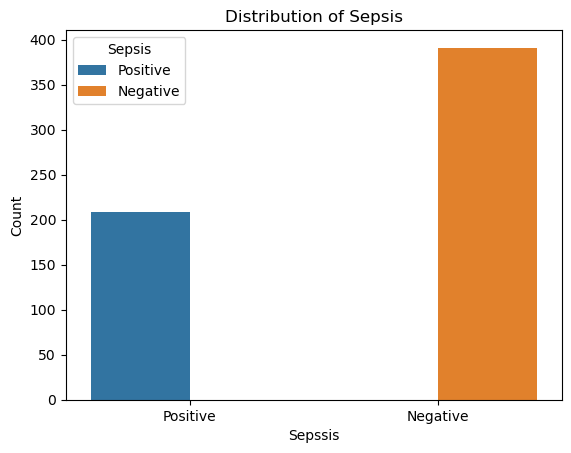

In [13]:
# Class distribution for the 'Sepssis' target variable
sns.countplot(data=df_train, x='Sepsis', hue='Sepsis')
plt.title('Distribution of Sepsis')
plt.xlabel('Sepssis')
plt.ylabel('Count')
plt.show()

**Observations:**

Class Distribution: The visualization shows the distribution of 'Sepssis' classes.

Imbalance: It's imbalanced, with more 'Negative' than 'Positive' cases.

Importance: This balance affects model training and may need special handling.

Handling: Techniques like oversampling or undersampling can address the imbalance.

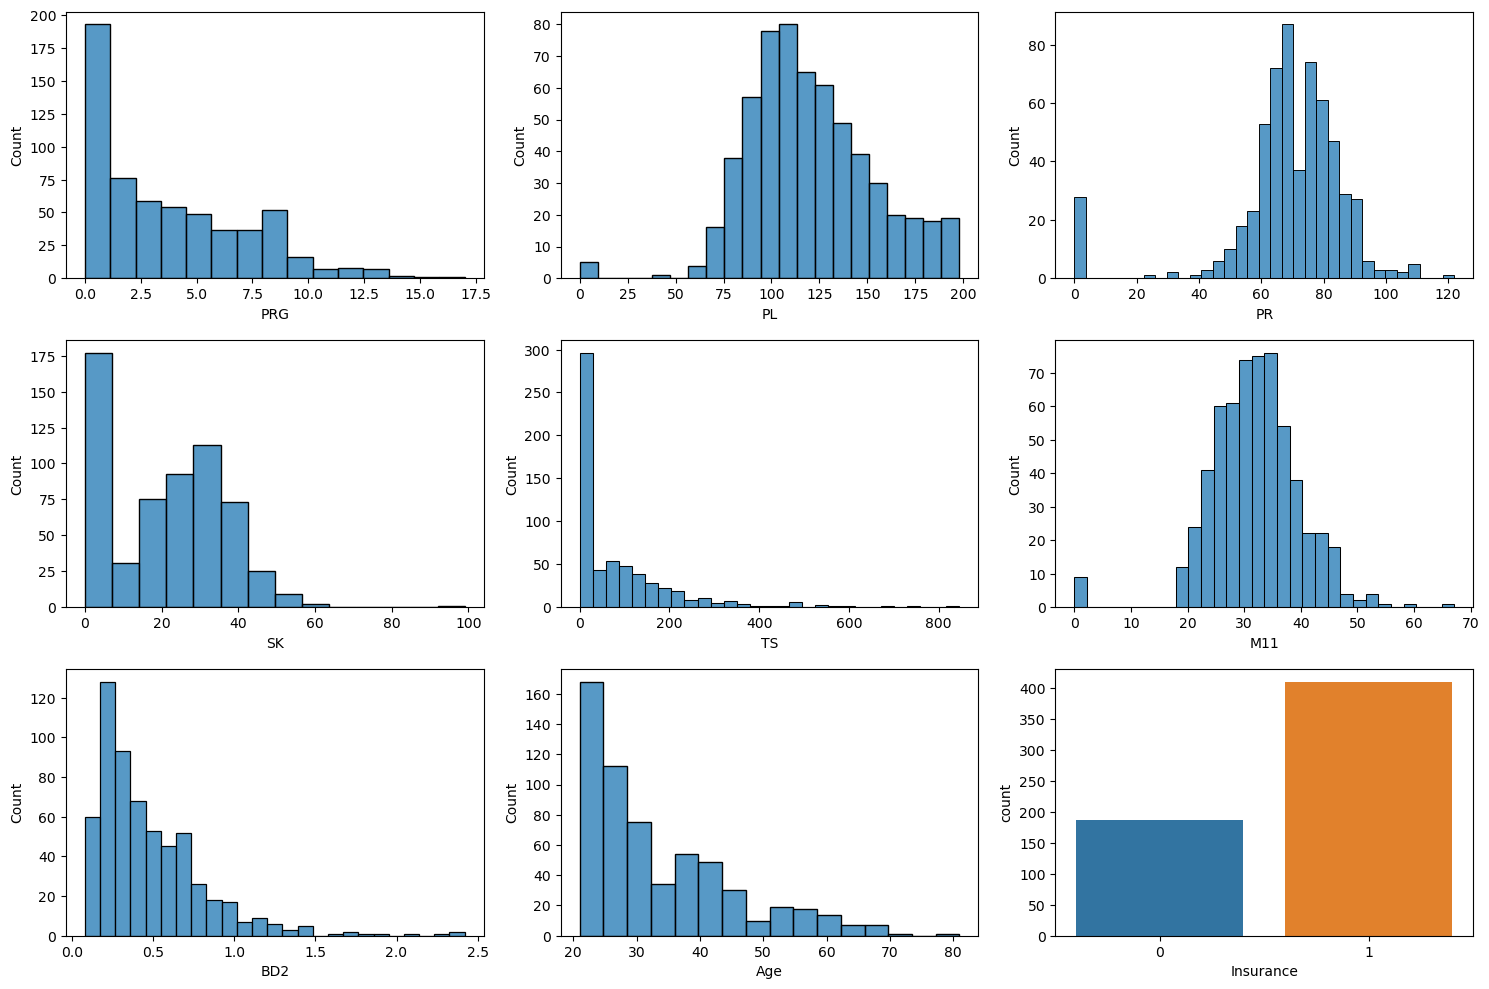

In [14]:
# Create subplots for numerical features
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Plot histograms for numerical features
sns.histplot(data=df_train, x='PRG', ax=axes[0, 0])
sns.histplot(data=df_train, x='PL', ax=axes[0, 1])
sns.histplot(data=df_train, x='PR', ax=axes[0, 2])
sns.histplot(data=df_train, x='SK', ax=axes[1, 0])
sns.histplot(data=df_train, x='TS', ax=axes[1, 1])
sns.histplot(data=df_train, x='M11', ax=axes[1, 2])
sns.histplot(data=df_train, x='BD2', ax=axes[2, 0])
sns.histplot(data=df_train, x='Age', ax=axes[2, 1])

# Insurance can be treated as categorical for this analysis
sns.countplot(data=df_train, x='Insurance', ax=axes[2, 2])

plt.tight_layout()
plt.show()


## Bivariate Analysis

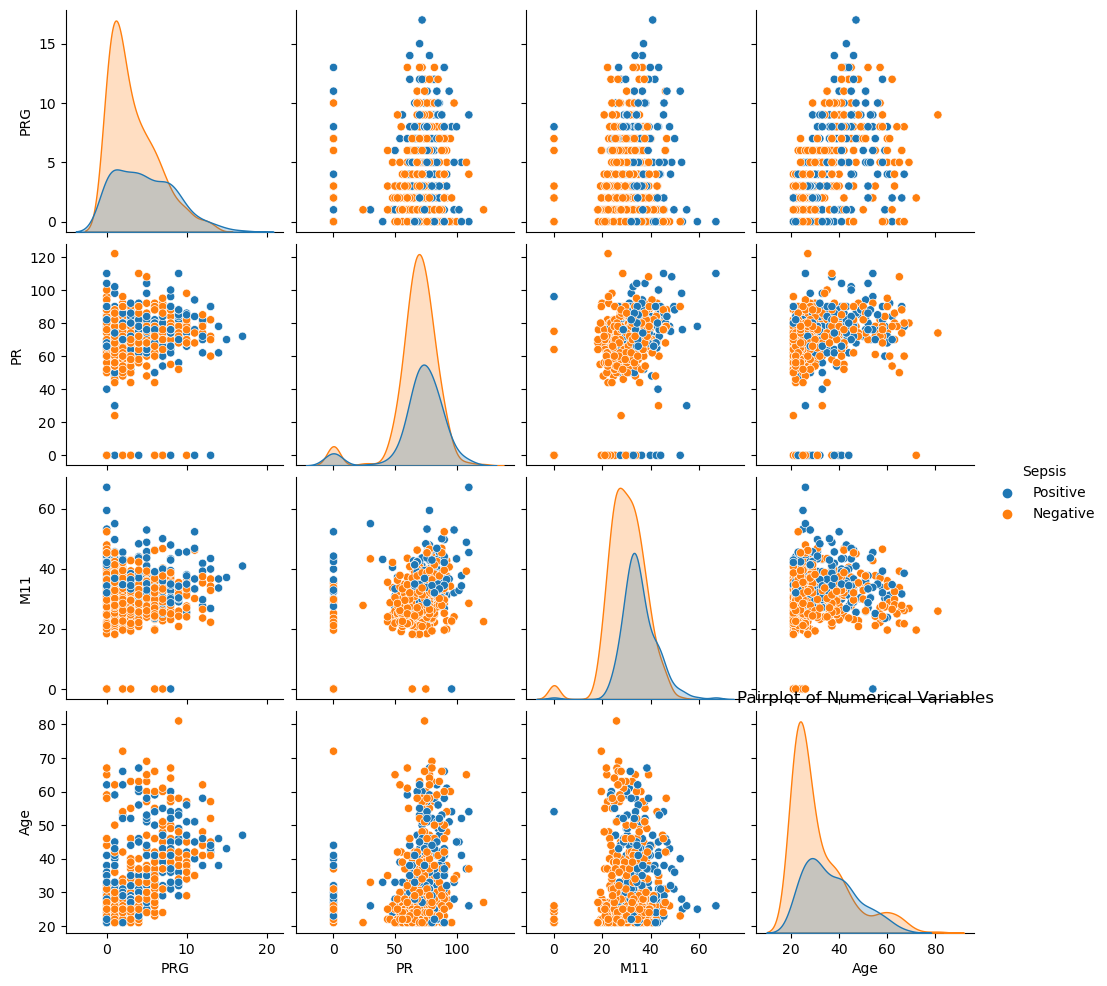

In [15]:
# Pairplot to visualize relationships between numerical variables
sns.pairplot(df_train, hue='Sepsis', vars=['PRG', 'PR', 'M11', 'Age'])
plt.title('Pairplot of Numerical Variables')
plt.show()

**Observation:**

Pairplot Summary - Numerical Features for Sepsis Prediction:

The pairplot examines how numerical attributes (Plasma Glucose, Blood Pressure, BMI, Age) relate to sepsis presence.

1. Overall Distribution: No clear separation between sepsis (positive) and non-sepsis (negative) cases.

2. Outliers: Identifies potential outliers for further investigation.

3. Clustering: Shows feature combinations common to both sepsis and non-sepsis cases.

4. Linearity: Reveals potential linear relationships among features.

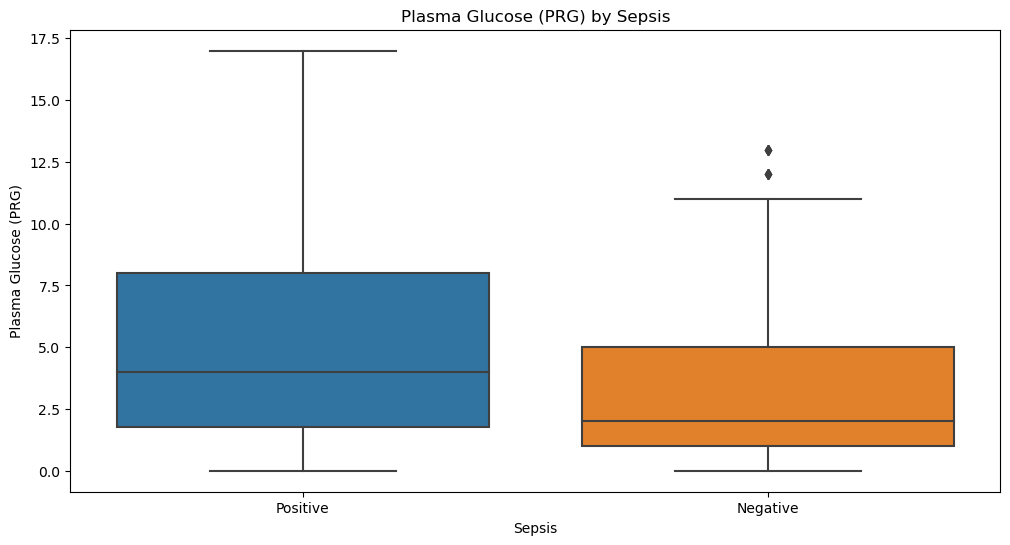

In [16]:
# Box plots for numerical variables by 'Sepsis'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sepsis', y='PRG', data=df_train)
plt.title('Plasma Glucose (PRG) by Sepsis')
plt.xlabel('Sepsis')
plt.ylabel('Plasma Glucose (PRG)')
plt.show()

**Observation:**

This visualization helps assess the differences in 'Plasma Glucose' levels between sepsis (Positive) and non-sepsis (Negative) cases:

- Box Length and Position: The 'Positive' group has a wider range of plasma glucose levels.
- Median Values: 'Positive' cases have a higher median glucose level compared to 'Negative' cases.
- Outliers: Some 'Negative' cases have unusually high glucose levels.
- Interquartile Range (IQR): 'Positive' cases exhibit greater variability in glucose levels.

In summary, the chart suggests significant differences in plasma glucose levels, with 'Positive' cases having higher median levels and wider variability.

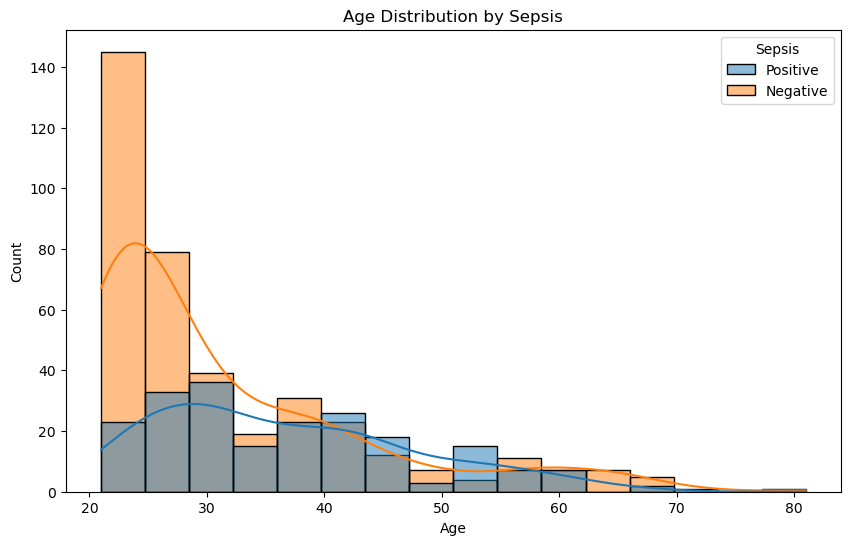

In [17]:
# Histograms for age distribution by 'Sepsis'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='Age', hue='Sepsis', kde=True)
plt.title('Age Distribution by Sepsis')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

**Observation:**

- Sepsis tends to affect older individuals more frequently.
- Younger age groups have a lower likelihood of sepsis.
- Healthcare strategies for sepsis prevention and management should consider age-related patterns.

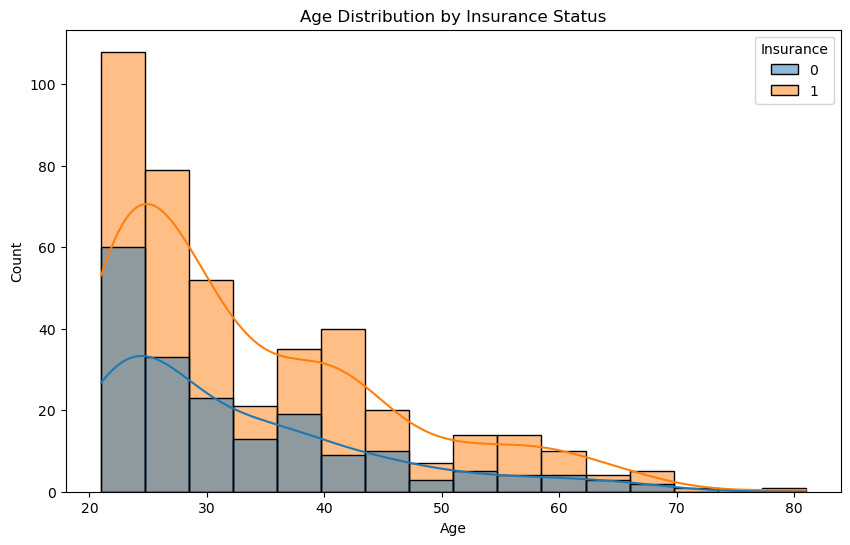

In [18]:
# Example for age distribution by 'Insurance'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='Age', hue='Insurance', kde=True)
plt.title('Age Distribution by Insurance Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


In [19]:
# Define age groups
age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']

# Create a new column 'AgeGroup' based on age bins
df_train['AgeGroup'] = pd.cut(df_train['Age'], bins=age_bins, labels=age_labels)

# Print the age distribution by 'Insurance' and 'AgeGroup'
age_group_by_insurance = df_train.groupby(['Insurance', 'AgeGroup']).size().unstack().fillna(0)
print("Age Distribution by Insurance Status and Age Group:")
print(age_group_by_insurance)


Age Distribution by Insurance Status and Age Group:
AgeGroup   0-19  20-29  30-39  40-49  50-59  60-69  70-79  80-89  90+
Insurance                                                            
0             0    106     43     21     12      6      0      0    0
1             0    217     85     60     33     14      1      1    0


**Observationn:**

1. **Age and Insurance**: The 20-29 age group is notable for having the highest number of patients, both insured and uninsured. This suggests that insurance coverage is a significant consideration for individuals in this age range.

2. **Age Distribution**: Older age groups (70-79, 80-89, 90+) have fewer uninsured patients compared to insured patients, indicating a preference for insurance coverage among older demographics.

Understanding these age and insurance distribution trends can inform healthcare planning and strategies, particularly for addressing insurance needs among different age groups.

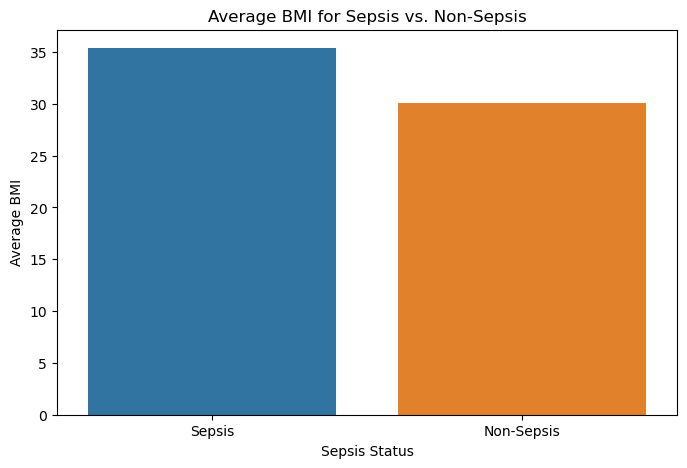

In [20]:
# Calculate and visualize the average BMI for sepsis and non-sepsis groups
sepsis_bmi_avg = df_train[df_train['Sepsis'] == 'Positive']['M11'].mean()
non_sepsis_bmi_avg = df_train[df_train['Sepsis'] == 'Negative']['M11'].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=['Sepsis', 'Non-Sepsis'], y=[sepsis_bmi_avg, non_sepsis_bmi_avg])
plt.title('Average BMI for Sepsis vs. Non-Sepsis')
plt.xlabel('Sepsis Status')
plt.ylabel('Average BMI')
plt.show()

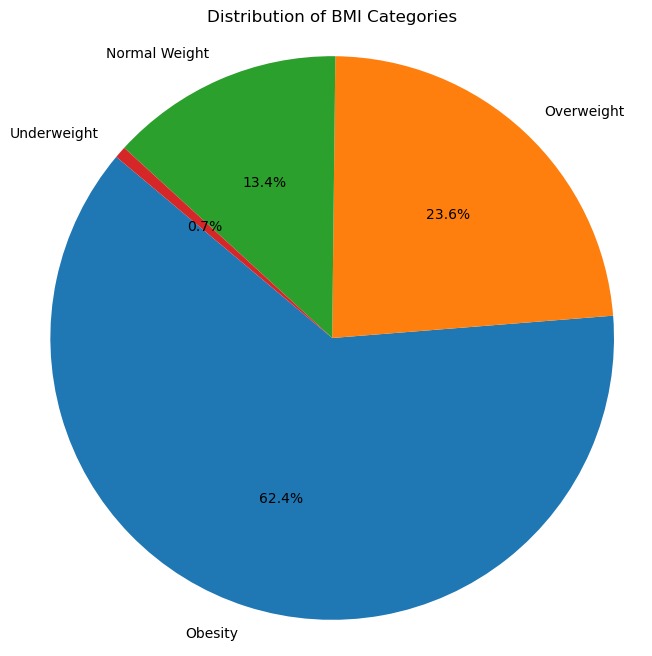

In [21]:
# Define BMI categories and corresponding labels
bmi_categories = ['Underweight', 'Normal Weight', 'Overweight', 'Obesity']
bmi_ranges = [0, 18.5, 24.9, 29.9, float('inf')]

# Create a new column 'BMI Category' based on BMI ranges
df_train['BMI Category'] = pd.cut(df_train['M11'], bins=bmi_ranges, labels=bmi_categories)

# Count the number of individuals in each BMI category
bmi_category_counts = df_train['BMI Category'].value_counts()

# Count the number of individuals in each BMI category
bmi_category_counts = df_train['BMI Category'].value_counts()

# Create a pie chart to visualize BMI categories
plt.figure(figsize=(8, 8))
plt.pie(bmi_category_counts, labels=bmi_category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of BMI Categories')
plt.axis('equal')  

plt.show()


**Observation**: 

- The pie chart illustrates the distribution of BMI (Body Mass Index) categories in the dataset. The majority of individuals fall into the "Obesity" category, representing 62% of the dataset. Additionally, 23% are categorized as "Overweight," 13.4% as "Normal Weight," and a smaller percentage, 0.7%, as "Underweight." This information provides an overview of the BMI distribution within the dataset, highlighting a significant proportion of individuals in the "Obesity" category.

## Multivariate Analysis

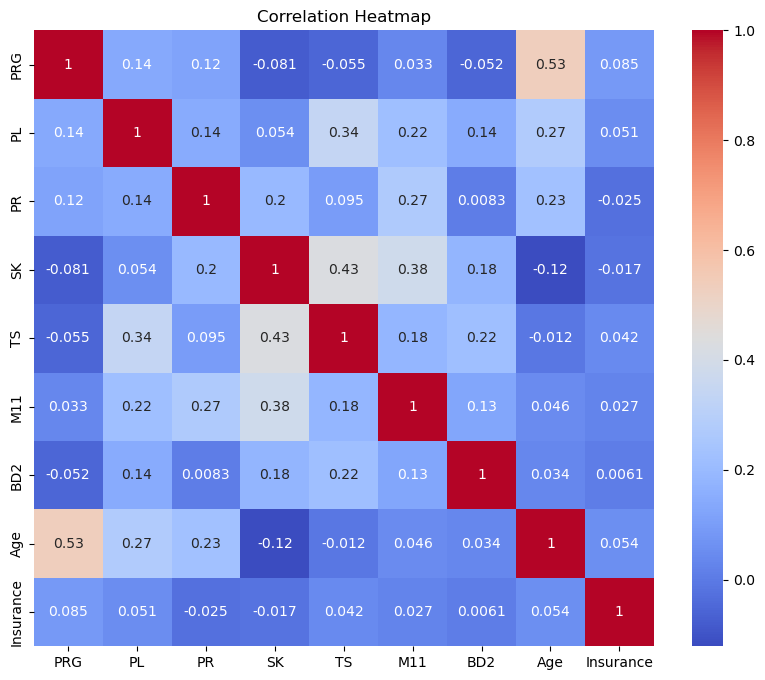

In [22]:
# Correlation heatmap for numerical variables
correlation_matrix = df_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

**Observation:**

1. **Correlation Strength**: The heatmap displays the strength of correlations between numerical variables, with warmer colors indicating positive correlations and cooler colors indicating negative correlations.

2. **Multicollinearity**: The heatmap helps identify potential multicollinearity issues, where some variables are highly correlated. High correlations can affect model stability and interpretability.

3. **Key Observation**: Notable is the strong positive correlation (0.48) between 'TS' and 'SK,' suggesting they tend to increase together. Consider if both are needed as separate features.

In [23]:
# Target Variable distribution by percentage
100*df_train['Sepsis'].value_counts()/len(df_train['Sepsis'])

Negative    65.275459
Positive    34.724541
Name: Sepsis, dtype: float64

In [24]:
df_train['Sepsis'].value_counts()

Negative    391
Positive    208
Name: Sepsis, dtype: int64

* Data is highly imbalanced, ratio=65:35

## Questions

### 1. Is there a difference in plasma glucose levels (PRG) between patients with and without sepsis?


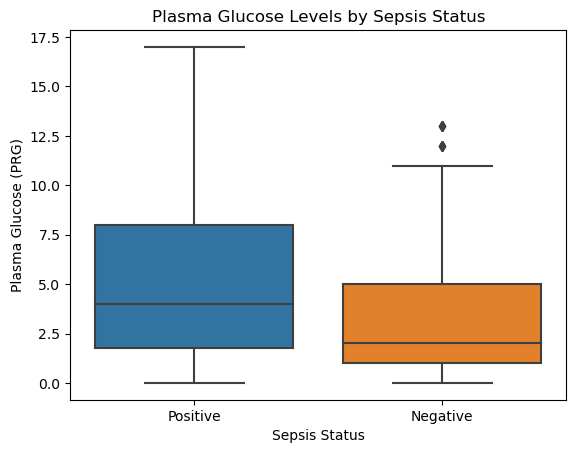

In [25]:
# Create a box plot to visualize the difference in PRG by sepsis status
sns.boxplot(data=df_train, x='Sepsis', y='PRG')
plt.title('Plasma Glucose Levels by Sepsis Status')
plt.xlabel('Sepsis Status')
plt.ylabel('Plasma Glucose (PRG)')
plt.show()

**Observation:**
- Patients with sepsis (Sepsis Status = 1) exhibit higher median PRG levels, around 4, compared to those without sepsis (Sepsis Status = 0), where the median PRG is below 2.5.
- PRG levels among patients with sepsis show greater variability, as indicated by the wider interquartile range (IQR) and the presence of outliers.
- The noticeable difference in PRG levels between the two groups suggests a potential association between elevated PRG and sepsis.

### 2. How does age vary between patients with and without sepsis?

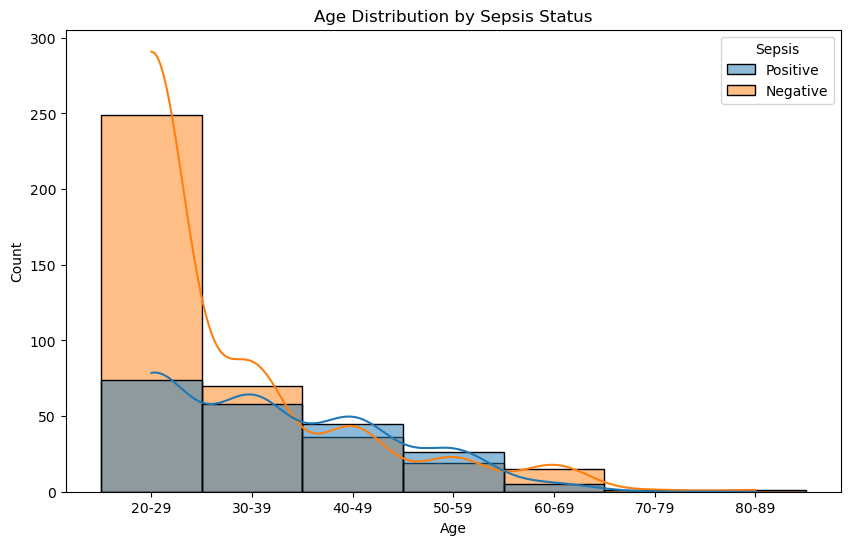

In [26]:
# Create histograms to compare the age distribution of sepsis and non-sepsis patients
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='AgeGroup', hue='Sepsis', kde=True)
plt.title('Age Distribution by Sepsis Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


The age distribution histogram compares sepsis (1) and non-sepsis (0) patients, showing:

1. Lower sepsis incidence in the 20-29 age group.
2. Increased incidence with age.
3. KDE curves provide data distribution insights.

### 3. Are there differences in blood pressure (PR) between Sepsis Status?

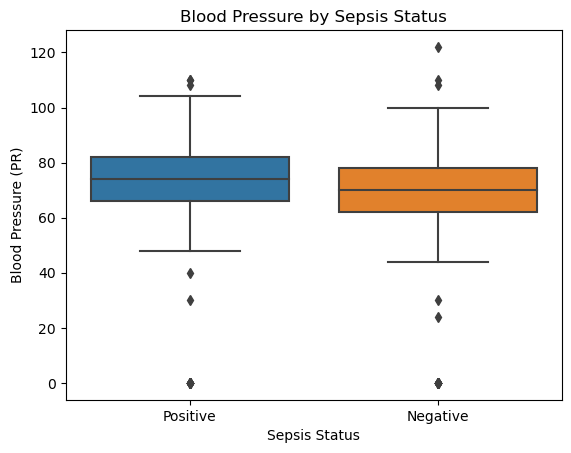

In [27]:
# Create a box plot to visualize the difference in blood pressure by insurance status
sns.boxplot(data=df_train, x='Sepsis', y='PR')
plt.title('Blood Pressure by Sepsis Status')
plt.xlabel('Sepsis Status')
plt.ylabel('Blood Pressure (PR)')
plt.show()

The box plot illustrates the distribution of blood pressure (PR) levels for patients with Sepsis (Positive) and without Sepsis (Negative).

**Key Insights:**
- Sepsis-positive and Sepsis-negative patients exhibit slightly different mean blood pressure levels, with averages of approximately 77 and 74, respectively.

### 4.  Is there an association between plasma glucose levels (PRG) and blood pressure (PR)?

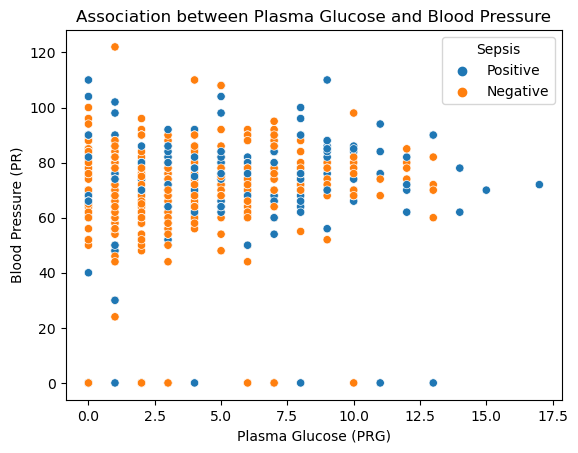

In [28]:
# Create a scatter plot to visualize the relationship between PRG and PR
sns.scatterplot(data=df_train, x='PRG', y='PR', hue='Sepsis')
plt.title('Association between Plasma Glucose and Blood Pressure')
plt.xlabel('Plasma Glucose (PRG)')
plt.ylabel('Blood Pressure (PR)')
plt.show()

**Key Observations:**
- The scatter plot shows a positive correlation between plasma glucose levels (PRG) and blood pressure (PR) among patients. As PRG increases, blood pressure tends to increase. Orange dots represent sepsis cases, while blue dots represent non-sepsis cases. This suggests a potential relationship worth exploring.

### 5.What is the distribution of body mass index (BMI - M11) across different age groups?

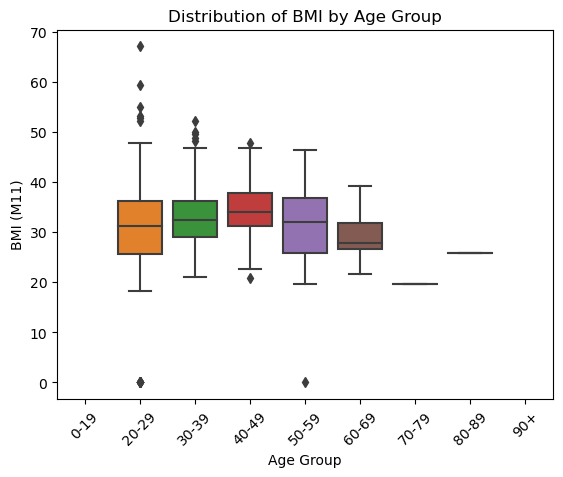

In [29]:
# Create a box plot to visualize the distribution of BMI by age group
sns.boxplot(data=df_train, x='AgeGroup', y='M11')
plt.title('Distribution of BMI by Age Group')
plt.xlabel('Age Group')
plt.ylabel('BMI (M11)')
plt.xticks(rotation=45)
plt.show()


**Key Insights:**

- "40-49" age group has the highest median BMI, around 35, indicating higher BMIs in their forties.
- "50-59" age group also shows elevated median BMI, suggesting higher BMIs in their fifties.
- "20-29" age group exhibits one of the lowest median BMIs, around 30, for individuals in their twenties.
- Variability in BMI is evident within each age group.

## 6. The prevalence of obesity in specific age groups?

<Figure size 1000x600 with 0 Axes>

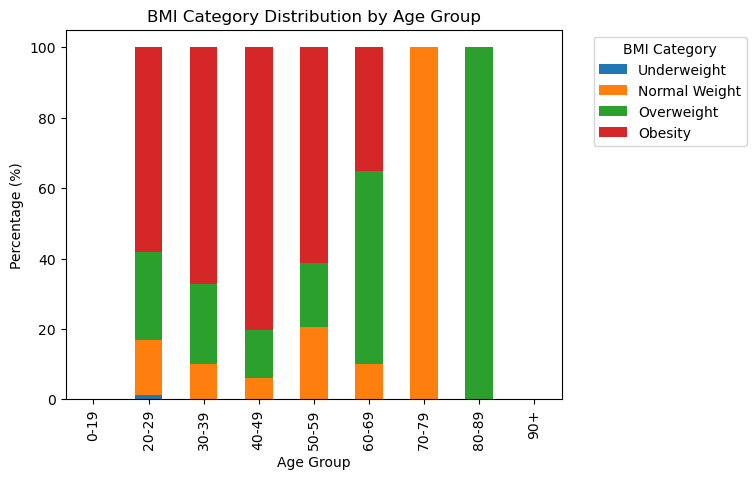

In [30]:
# Define BMI categories and corresponding labels
bmi_categories = ['Underweight', 'Normal Weight', 'Overweight', 'Obesity']
bmi_ranges = [0, 18.5, 24.9, 29.9, float('inf')]

# Create a new column 'BMI Category' based on BMI ranges
df_train['BMI Category'] = pd.cut(df_train['M11'], bins=bmi_ranges, labels=bmi_categories)

# Calculate the percentages of each BMI category within each age group
agegroup_bmi_percentages = df_train.groupby(['AgeGroup', 'BMI Category']).size().unstack(fill_value=0)
agegroup_bmi_percentages = agegroup_bmi_percentages.div(agegroup_bmi_percentages.sum(axis=1), axis=0) * 100

# Create a stacked bar chart
plt.figure(figsize=(10, 6))
agegroup_bmi_percentages.plot(kind='bar', stacked=True)
plt.title('BMI Category Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage (%)')
plt.legend(title='BMI Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

**Observation:**

- The stacked bar chart reveals that the age group 40-49 has the highest percentage of individuals classified as "Obesity," while the age group 20-29 shows the highest percentage of individuals with a "Normal Weight."

### 7. How does the prevalence of sepsis vary across different age groups?

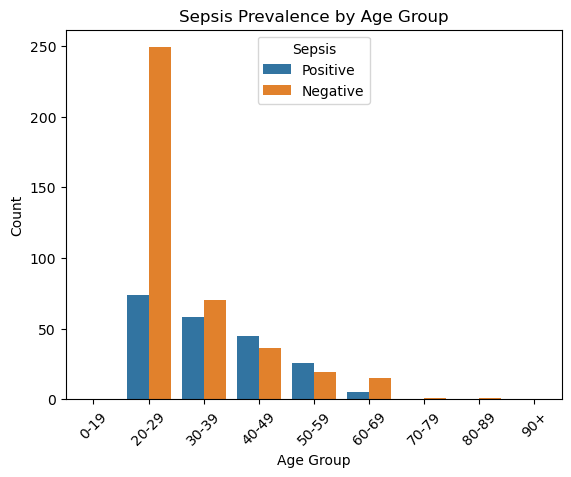

In [31]:
# Create a count plot to visualize sepsis prevalence by age group
sns.countplot(data=df_train, x='AgeGroup', hue='Sepsis')
plt.title('Sepsis Prevalence by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**Key Insight:**

Among the age groups examined, individuals in the 20-29 age group have the lowest prevalence of sepsis, indicating a lower incidence of sepsis cases in this age range.

### 8. Are there differences in plasma glucose levels (PRG) among patients with different insurance statuses, considering their age?

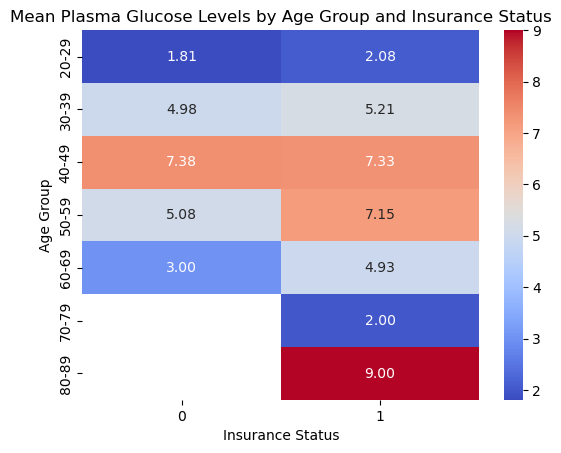

In [32]:
# Create a heatmap to visualize the mean PRG values by age group and insurance status
pivot_table = df_train.pivot_table(index='AgeGroup', columns='Insurance', values='PRG', aggfunc='mean')
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Mean Plasma Glucose Levels by Age Group and Insurance Status')
plt.xlabel('Insurance Status')
plt.ylabel('Age Group')
plt.show()

The heatmap displays mean plasma glucose levels (PRG) by age groups and insurance statuses, revealing age-specific trends.

**Key Insights:**

1. Age 20-29: Lower PRG levels, minimal insurance impact.
2. Age 30-39: PRG increases with age, influenced by lifestyle and healthcare.
3. Age 40-49: Elevated PRG levels, minimal insurance effect.

In summary, PRG rises with age, affected by various factors, with insurance having limited impact.

## HYPOTHESIS

### Age Distribution by Insurance Status

**Null Hypothesis (H0)**: There is no significant difference in age distribution between insured and uninsured patients.

**Alternative Hypothesis (H1)**: There is a significant difference in age distribution between insured and uninsured patients.

In [33]:
# Age Distribution by Insurance Status
insured_age = df_train[df_train['Insurance'] == 1]['Age']
uninsured_age = df_train[df_train['Insurance'] == 0]['Age']
t_stat, p_value = stats.ttest_ind(insured_age, uninsured_age, equal_var=False)

# Set the significance level
alpha = 0.05

print(" Age Distribution by Insurance Status:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


if p_value < alpha:
    print("Reject Null Hypothesis: There is a significant difference in age distribution between insured and uninsured patients.")
else:
    print("Accept Null Hypothesis: There is no significant difference in age distribution between insured and uninsured patients.")

 Age Distribution by Insurance Status:
T-statistic: 1.359114005409477
P-value: 0.17491186636473033
Accept Null Hypothesis: There is no significant difference in age distribution between insured and uninsured patients.


### Plasma Glucose Levels by Sepsis Status

**Null Hypothesis (H0)**: The mean plasma glucose levels are the same for patients with and without sepsis.

**Alternative Hypothesis (H1)**: The mean plasma glucose levels are different between patients with and without sepsis.

In [34]:
# Hypothesis 1: Plasma Glucose Levels by Sepsis Status
sepsis_group = df_train[df_train['Sepsis'] == 'Positive']['PRG']
non_sepsis_group = df_train[df_train['Sepsis'] =='Negative']['PRG']
t_stat, p_value = stats.ttest_ind(sepsis_group, non_sepsis_group, equal_var=False)

# Set the significance level
alpha = 0.05

print(" Plasma Glucose Levels by Sepsis Status:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Reject Null Hypothesis:There is a significant difference in plasma glucose levels between patients with and without sepsis.")
else:
    print("Accept Null Hypothesis:There is no significant difference in plasma glucose levels between patients with and without sepsis.")


 Plasma Glucose Levels by Sepsis Status:
T-statistic: 4.842533902324343
P-value: 1.924247139438273e-06
Reject Null Hypothesis:There is a significant difference in plasma glucose levels between patients with and without sepsis.


### Blood Pressure by Sepsis Status

**Null Hypothesis (H0)**: There is no significant difference in blood pressure level Sepsis Status.

**Alternative Hypothesis (H1)**: There is a significant difference in blood pressure level Sepsis Status.

In [35]:
from scipy.stats import mannwhitneyu

# Split the data into two groups based on sepsis status
blood_pressure_sepsis = df_train[ df_train['Sepsis'] == 'Positive']['PR']
blood_pressure_no_sepsis =  df_train[ df_train['Sepsis'] == 'Negative']['PR']

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(blood_pressure_sepsis, blood_pressure_no_sepsis)
# Print the test statistic (t-statistic)
print("Mann-Whitney U Test Statistic:", statistic)

# Print the p-value
print("P-Value:", p_value)

# Set the significance level (alpha)
alpha = 0.05

# Check the result based on the significance level
if p_value < alpha:
    print("Reject Null Hypothesis:There is a significant difference in blood pressure between sepsis and non-sepsis groups.")
else:
    print("Accept Null Hypothesis:There is no significant difference in blood pressure between sepsis and non-sepsis groups.")


Mann-Whitney U Test Statistic: 47673.5
P-Value: 0.0005014049708706393
Reject Null Hypothesis:There is a significant difference in blood pressure between sepsis and non-sepsis groups.


### Age Distribution by Sepsis Status

**Null Hypothesis (H0)**: The age distributions are the same for patients with and without sepsis.

**Alternative Hypothesis (H1)**: The age distributions are different between patients with and without sepsis.

In [36]:
# Hypothesis 3: Age Distribution by Sepsis Status (Kolmogorov-Smirnov test)
sepsis_age = df_train[df_train['Sepsis'] == 'Positive']['Age']
non_sepsis_age = df_train[df_train['Sepsis'] == 'Negative']['Age']
ks_stat, p_value = stats.ks_2samp(sepsis_age, non_sepsis_age)
print("Age Distribution by Sepsis Status:")
print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

# Set the significance level
alpha = 0.05

if p_value < alpha:
    print("Reject Null Hypothesis:The age distribution differs significantly between patients with and without sepsis.")
else:
    print("Accept Null Hypothesis:There is no significant difference in age distribution between patients with and without sepsis.")


Age Distribution by Sepsis Status:
KS Statistic: 0.31081546330906945
P-value: 4.148871074130695e-12
Reject Null Hypothesis:The age distribution differs significantly between patients with and without sepsis.


### BMI by Sepsis Status

**Null Hypothesis (H0)**: There is no significant difference between in BMI Sepsis Status.

**Alternative Hypothesis (H1)**: There is a significant difference between in BMI and Sepsis Status.

In [37]:
# Hypothesis 4: BMI by Insurance Status (Using Mann-Whitney U Test)
insured_bmi = df_train[df_train['Sepsis'] == 'Positive']['M11']
uninsured_bmi = df_train[df_train['Sepsis'] == 'Negative']['M11']
u_stat, p_value = stats.mannwhitneyu(insured_bmi, uninsured_bmi, alternative='two-sided')
print("BMI by Sepsis Status (Mann-Whitney U Test):")
print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")

# Set the significance level
alpha = 0.05

# Hypothesis 4: BMI by Insurance Status
if p_value < alpha:
    print("Reject Null Hypothesis: There is a significant difference between BMI and Sepsis Status.")
else:
    print("Accept Null Hypothesis:There is no significant difference between BMI and Sepsis Status.")


BMI by Sepsis Status (Mann-Whitney U Test):
U-statistic: 56864.0
P-value: 9.46574491775568e-16
Reject Null Hypothesis: There is a significant difference between BMI and Sepsis Status.


### Association between BMI Category and Sepsis

**Null Hypothesis (H0):** There is no significant association between BMI Category and Sepsis. In other words, the distribution of Sepsis is independent of BMI Category.

**Alternative Hypothesis (H1):** There is a significant association between BMI Category and Sepsis. In other words, the distribution of Sepsis is not independent of BMI Category.

In [38]:
# Create a contingency table of BMI Category and Sepsis
contingency_table = pd.crosstab(df_train['BMI Category'], df_train['Sepsis'])

# Perform a chi-squared test of independence
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("Association between BMI Category and Sepsis")
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p_value}")

# Set the significance level
alpha = 0.05

# Hypothesis Test: BMI Category and Sepsis
if p_value < alpha:
    print("Reject Null Hypothesis:There is a significant association between BMI Category and Sepsis.")
else:
    print("Accept Null Hypothesis:There is no significant association between BMI Category and Sepsis.")

Association between BMI Category and Sepsis
Chi-squared statistic: 69.80883027401862
P-value: 4.690218497862507e-15
Reject Null Hypothesis:There is a significant association between BMI Category and Sepsis.


In [39]:

# create a contingency table
contingency_table = pd.crosstab(df_train['Sepsis'], df_train['Insurance'])

# Perform the chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Set the significance level
alpha = 0.05

# Print the results
print(f"Chi-Squared Value: {chi2}")
print(f"P-Value: {p}")

# Check the result based on the significance level
if p < alpha:
    print("Reject Null Hypothesis: There is a significant association between Sepsis and Insurance.")
else:
    print("Accept Null Hypothesis: There is no significant association between Sepsis and Insurance.")

Chi-Squared Value: 2.0712782081677066
P-Value: 0.1500956791860619
Accept Null Hypothesis: There is no significant association between Sepsis and Insurance.


## Feature Processing & Engineering

* This includes Dropping missing values and other feature important processes 

In [40]:
df_train.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepsis,AgeGroup,BMI Category
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive,40-49,Obesity
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative,30-39,Overweight
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive,30-39,Normal Weight
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative,20-29,Overweight
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive,30-39,Obesity


In [41]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'Sepsis' column
df_train['Sepsis'] = label_encoder.fit_transform(df_train['Sepsis'])

# Verify the conversion
df_train['Sepsis'].unique

<bound method Series.unique of 0      1
1      0
2      1
3      0
4      1
      ..
594    0
595    1
596    0
597    0
598    1
Name: Sepsis, Length: 599, dtype: int32>

In [ ]:
# # Convert "Insurance" column to categorical/ nominal categorical binary variable 
# df_train['Insurance'] = df_train['Insurance'].astype('category')

# # Verify the conversion
# df_train['Insurance'].dtype


In [42]:
# Drop unnecessary columns
df_train = df_train.drop(columns=['ID', 'AgeGroup', 'BMI Category','Insurance'])

In [43]:
df_train.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepsis
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [44]:
df_train.dtypes

PRG         int64
PL          int64
PR          int64
SK          int64
TS          int64
M11       float64
BD2       float64
Age         int64
Sepsis      int32
dtype: object

In [45]:
Numerical = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2','Age']

In [ ]:
# Categorical= ['Insurance']

## Data Splitting 

In [46]:
X = df_train.drop(columns = "Sepsis")
y = df_train["Sepsis"].values

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify =y)

In [48]:
print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)

Training set size: (479, 8) (479,)
Testing set size: (120, 8) (120,)


## Impute Missing Values

In [ ]:
# # Impute missing values with the mode for categorical features
# categorical_imputer = SimpleImputer(strategy='most_frequent')

# X_train_imputer = categorical_imputer.fit_transform(X_train[Categorical])
# X_test_imputer = categorical_imputer.transform(X_test[Categorical])

In [49]:
# Create a SimpleImputer for numerical features
numerical_imputer = SimpleImputer(strategy='mean')  
# Fit and transform the imputer on your training data
X_train_imputer = numerical_imputer.fit_transform(X_train[Numerical])

# Transform the imputer on your test data (without fitting to avoid data leakage)
X_test_imputer = numerical_imputer.transform(X_test[Numerical])


In [50]:
print(Numerical)
# print(Categorical)

['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']


## Feature Encoding

In [ ]:
# # Apply one-hot encoding on the training set
# encoder = OneHotEncoder(drop='if_binary')
# X_train_encoding = pd.DataFrame(encoder.fit_transform(X_train[Categorical]).toarray(),
#                                columns=encoder.get_feature_names_out(Categorical),
#                                index=X_train.index)

# # Apply the same encoding on the testing set
# X_test_encoding = pd.DataFrame(encoder.transform(X_test[Categorical]).toarray(),
#                               columns=encoder.get_feature_names_out(Categorical),
#                               index=X_test.index)

## Feature Scaling

In [ ]:
# # Create an instance of the StandardScaler
# scaler = StandardScaler()

# # Fit and transform the numeric variables in the training set
# X_train_encoding[Numerical] = scaler.fit_transform(X_train[Numerical])

# # Transform the numeric variables in the testing set using the fitted scaler
# X_test_encoding[Numerical] = scaler.transform(X_test[Numerical])

In [51]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit and transform the numeric variables in the training set
X_train_scaled = X_train.copy()  
X_train_scaled[Numerical] = scaler.fit_transform(X_train_scaled[Numerical])

# Transform the numeric variables in the testing set using the fitted scaler
X_test_scaled = X_test.copy()  # Create a copy of X_test_encoding
X_test_scaled[Numerical] = scaler.transform(X_test_scaled[Numerical])

# Create a DataFrame to hold the scaled data
scaled = pd.concat([X_train_scaled, X_test_scaled])

In [52]:
# Concatenate the encoded & scaled training and testing sets
X_encode = pd.concat([X_train_scaled, X_test_scaled], axis=0)

In [53]:
X_train_scaled.shape
X_test_scaled.shape

(120, 8)

In [54]:
X_encode

,PRG,PL,PR,SK,TS,M11,BD2,Age
161,0.936259,-0.541760,0.292468,1.227874,0.278949,0.706624,-0.824511,0.991413
236,0.936259,1.923458,0.812484,0.025886,1.108512,0.534049,0.260234,1.504619
497,-0.563634,-1.197071,0.188465,-0.353689,0.002429,-0.235902,0.149488,-0.719274
40,-0.263656,1.892252,-0.227548,0.278936,-0.054783,0.281824,-0.634255,-0.633740
372,-1.163592,-1.103456,-0.227548,0.089149,-0.092923,0.520774,0.143808,-1.061412
...,...,...,...,...,...,...,...,...
517,0.936259,0.175961,0.916487,-1.302627,-0.722247,0.759724,-0.540547,1.504619
94,-0.563634,0.706451,0.708481,-0.163901,-0.111994,-0.952752,0.757172,-1.061412
496,0.336302,-0.292118,-0.019541,-1.302627,-0.722247,-0.780177,-0.574623,-0.291603
582,2.436153,0.051140,0.500474,-0.227164,-0.722247,-0.713802,-0.668331,2.445497


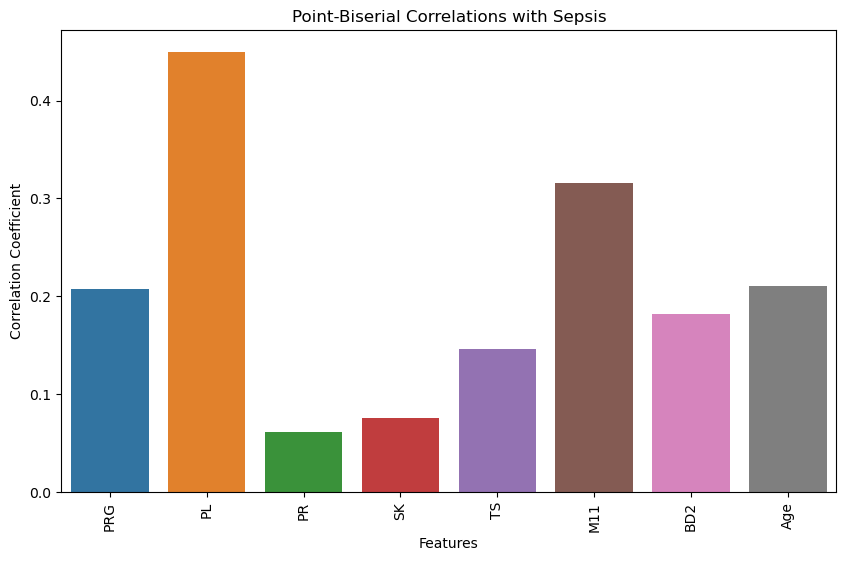

In [55]:
# Convert X_encode and y to DataFrames
X_encode_df = pd.DataFrame(X_encode, columns=X_encode.columns)
y_df = pd.DataFrame(y, columns=['Sepsis'])

# Combine X_encode_df with y_df
encoded_data = pd.concat([X_encode_df, y_df], axis=1)

# Calculate point-biserial correlations
correlations = encoded_data.corr()['Sepsis'].drop('Sepsis')  
# Plot the correlation coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title('Point-Biserial Correlations with Sepsis')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.show()

Positive Correlation: Higher values of these numerical features are linked to a higher likelihood of sepsis (Sepsis = 1).

- **PL (Blood Work Result-1):** Strongest correlation (>0.4), indicating a robust association with sepsis.

- **M11 (Body Mass Index):** Has a positive correlation, slightly lower than PL, suggesting higher BMI values increase sepsis likelihood.

- **Age:** Positively correlated, implying older age somewhat raises the chance of sepsis.

- **PR (Blood Pressure):** Weakest positive correlation (>0.0), indicating a relatively weaker link to sepsis compared to other features.

These correlations provide insights into feature relationships with sepsis, but causation is not implied. Further modeling is needed for predictive power assessment.

## Train Set Balancing

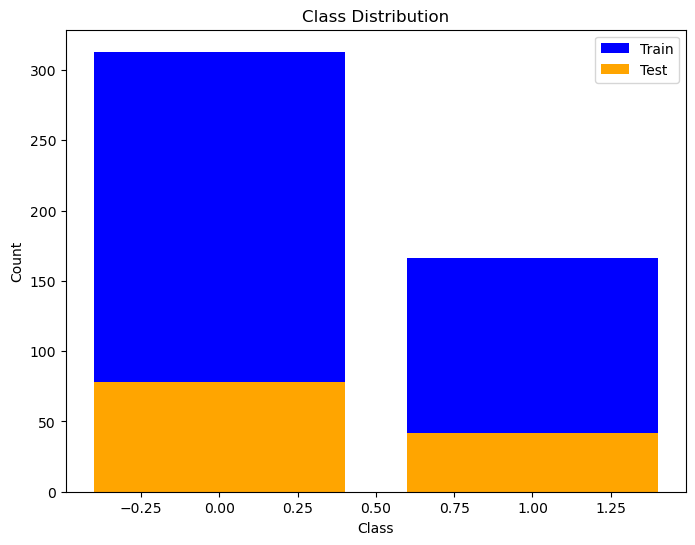

In [56]:
# Convert y_train and y_test to Pandas Series
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Count the number of samples in each class in the training set
train_class_counts = y_train_series.value_counts()

# Count the number of samples in each class in the testing set
test_class_counts = y_test_series.value_counts()

plt.figure(figsize=(8, 6))
plt.bar(train_class_counts.index, train_class_counts.values, color='blue', label='Train')
plt.bar(test_class_counts.index, test_class_counts.values, color='orange', label='Test')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.legend()
plt.show()

In [57]:
train_churn_count = pd.Series(y_train).value_counts()
test_churn_count = pd.Series(y_test).value_counts()

print("Sepsis count in y_train:")
print(train_churn_count)

print("\nSepsis count in y_test:")
print(test_churn_count)

Sepsis count in y_train:
0    313
1    166
dtype: int64

Sepsis count in y_test:
0    78
1    42
dtype: int64


**Observation:**

**Training Dataset:**
- Class 0 (absence of sepsis): 313 occurrences.
- Class 1 (presence of sepsis): 166 occurrences.

**Test Dataset:**
- Class 0: 78 occurrences.
- Class 1: 42 occurrences.

This summary provides an overview of the class distribution, indicating the balance between sepsis and non-sepsis cases in both datasets.

In [58]:
# Instantiate the SMOTE object
smote = SMOTE(random_state=42) 

# Apply SMOTE to balance the training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Convert y_train_resampled to a Pandas Series for value_counts
y_train_balanced = pd.Series(y_train_balanced)

# Check the class distribution after applying SMOTE
print("Class distribution after SMOTE:")
print(y_train_balanced.value_counts())


Class distribution after SMOTE:
0    313
1    313
dtype: int64


In [59]:
X_train_balanced.shape
y_train_balanced.shape


(626,)

## Train & Evaluate Models

In [60]:
# Define the calculate_metrics function
def calculate_metrics(y_true, y_pred):
    metrics = {}
    metrics['f1_score'] = f1_score(y_true, y_pred)
    return metrics

In [61]:
# Initialize the models
models = [
    AdaBoostClassifier(random_state=4, n_estimators=100, learning_rate=0.1),
    xgb.XGBClassifier(random_state=4, n_estimators=100, learning_rate=0.1),
    lgb.LGBMClassifier(random_state=4, n_estimators=100, learning_rate=0.1),
    catboost.CatBoostClassifier(random_state=4, verbose=0, iterations=100),
    GradientBoostingClassifier(random_state=4, n_estimators=100, learning_rate=0.1),
    RandomForestClassifier(random_state=4, n_estimators=100),
    LogisticRegression(random_state=4)
]

In [62]:
model_names = [
    'AdaBoost',
    'XGBoost',
    'LightGBM',
    'CatBoost',
    'Gradient Boosting',
    'Random Forest',
    'Logistic Regression'
]

In [63]:
leaderboard_imbalanced = {}

for model, name in zip(models, model_names):
    # Convert data to NumPy arrays and ensure they are in the correct order
    X_train_scaled_np = np.ascontiguousarray(X_train_scaled.values)
    y_train_np = np.ascontiguousarray(y_train)
    X_test_scaled_np = np.ascontiguousarray(X_test_scaled.values)
    
    model.fit(X_train_scaled_np, y_train_np)
    y_pred = model.predict(X_test_scaled_np)
    metrics = calculate_metrics(y_test, y_pred)
    leaderboard_imbalanced[name] = metrics
    
    # Print the classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['No', 'Yes']))
    print()

# Create a DataFrame from the leaderboard dictionary
leaderboard_df = pd.DataFrame(leaderboard_imbalanced).transpose()

# Format the F1-score column to display with two decimal places
leaderboard_df['Imbalanced Data F1-score'] = leaderboard_df['f1_score'].map('{:.2f}'.format)

leaderboard_df.sort_values(by='Imbalanced Data F1-score', ascending=False, inplace=True)

leaderboard_df.index.name = 'Models'
leaderboard_df.reset_index(inplace=True)

print("Leaderboard: Imbalanced Data")
leaderboard_df.drop('f1_score', axis=1, inplace=True)
leaderboard_df

Classification Report for AdaBoost:
              precision    recall  f1-score   support

          No       0.78      0.82      0.80        78
         Yes       0.63      0.57      0.60        42

    accuracy                           0.73       120
   macro avg       0.71      0.70      0.70       120
weighted avg       0.73      0.73      0.73       120


Classification Report for XGBoost:
              precision    recall  f1-score   support

          No       0.77      0.81      0.79        78
         Yes       0.61      0.55      0.57        42

    accuracy                           0.72       120
   macro avg       0.69      0.68      0.68       120
weighted avg       0.71      0.72      0.71       120


[LightGBM] [Info] Number of positive: 166, number of negative: 313
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set 

Classification Report for CatBoost:
              precision    recall  f1-score   support

          No       0.78      0.79      0.79        78
         Yes       0.61      0.60      0.60        42

    accuracy                           0.73       120
   macro avg       0.70      0.70      0.70       120
weighted avg       0.72      0.72      0.72       120


Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

          No       0.79      0.85      0.81        78
         Yes       0.67      0.57      0.62        42

    accuracy                           0.75       120
   macro avg       0.73      0.71      0.72       120
weighted avg       0.74      0.75      0.75       120


Classification Report for Random Forest:
              precision    recall  f1-score   support

          No       0.77      0.78      0.78        78
         Yes       0.59      0.57      0.58        42

    accuracy                           0.71       120
   m

,Models,Imbalanced Data F1-score
0,Logistic Regression,0.63
1,Gradient Boosting,0.62
2,AdaBoost,0.60
3,CatBoost,0.60
4,Random Forest,0.58
5,XGBoost,0.57
6,LightGBM,0.56


In [64]:
leaderboard_balanced = {}

for model, name in zip(models, model_names):
    model.fit(X_train_balanced, y_train_balanced)
    
    # Convert X_test_encoded to a NumPy array and ensure it's in the correct order
    X_test_scaled_np = np.ascontiguousarray(X_test_scaled)
    
    y_pred = model.predict(X_test_scaled_np)
    metrics = calculate_metrics(y_test, y_pred)
    leaderboard_balanced[name] = metrics
    
    # Print the classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['No', 'Yes']))
    print()

# Create a DataFrame from the leaderboard dictionary
leaderboard_df1 = pd.DataFrame(leaderboard_balanced).transpose()

# Format the F1-score column to display with two decimal places
leaderboard_df1['Balanced Data F1-score'] = leaderboard_df1['f1_score'].map('{:.2f}'.format)

# Sort the DataFrame by F1-score in descending order
leaderboard_df1.sort_values(by='Balanced Data F1-score', ascending=False, inplace=True)

leaderboard_df1.index.name = 'Models'
leaderboard_df1.reset_index(inplace=True)

print("Leaderboard: Balanced Data")
leaderboard_df1.drop('f1_score', axis=1, inplace=True)
leaderboard_df1


Classification Report for AdaBoost:
              precision    recall  f1-score   support

          No       0.88      0.74      0.81        78
         Yes       0.63      0.81      0.71        42

    accuracy                           0.77       120
   macro avg       0.75      0.78      0.76       120
weighted avg       0.79      0.77      0.77       120


Classification Report for XGBoost:
              precision    recall  f1-score   support

          No       0.79      0.77      0.78        78
         Yes       0.59      0.62      0.60        42

    accuracy                           0.72       120
   macro avg       0.69      0.69      0.69       120
weighted avg       0.72      0.72      0.72       120


[LightGBM] [Info] Number of positive: 313, number of negative: 313
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 901
[LightGB

Classification Report for CatBoost:
              precision    recall  f1-score   support

          No       0.81      0.73      0.77        78
         Yes       0.58      0.69      0.63        42

    accuracy                           0.72       120
   macro avg       0.70      0.71      0.70       120
weighted avg       0.73      0.72      0.72       120


Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

          No       0.78      0.73      0.75        78
         Yes       0.55      0.62      0.58        42

    accuracy                           0.69       120
   macro avg       0.67      0.67      0.67       120
weighted avg       0.70      0.69      0.70       120


Classification Report for Random Forest:
              precision    recall  f1-score   support

          No       0.81      0.76      0.78        78
         Yes       0.60      0.67      0.63        42

    accuracy                           0.73       120
   m

,Models,Balanced Data F1-score
0,AdaBoost,0.71
1,Logistic Regression,0.65
2,CatBoost,0.63
3,Random Forest,0.63
4,LightGBM,0.61
5,XGBoost,0.60
6,Gradient Boosting,0.58


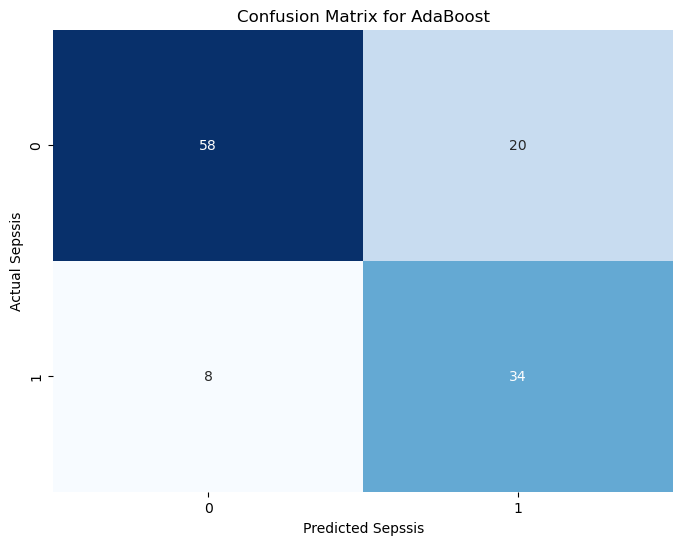

Confusion Matrix for AdaBoost:
[[58 20]
 [ 8 34]]



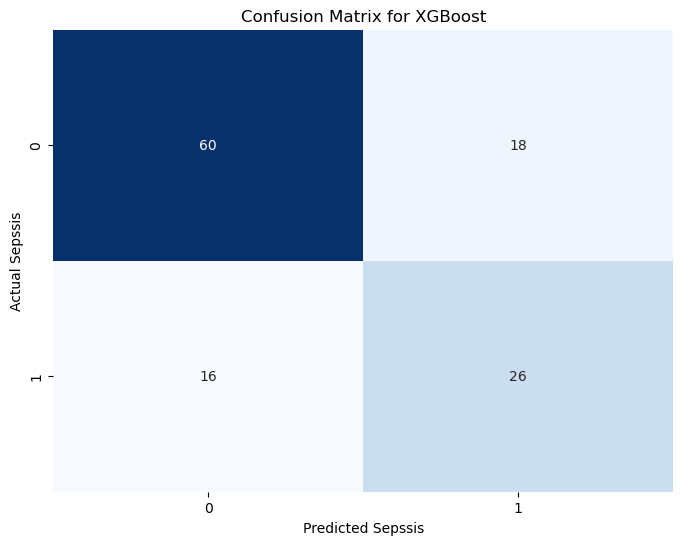

Confusion Matrix for XGBoost:
[[60 18]
 [16 26]]

[LightGBM] [Info] Number of positive: 313, number of negative: 313
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 901
[LightGBM] [Info] Number of data points in the train set: 626, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

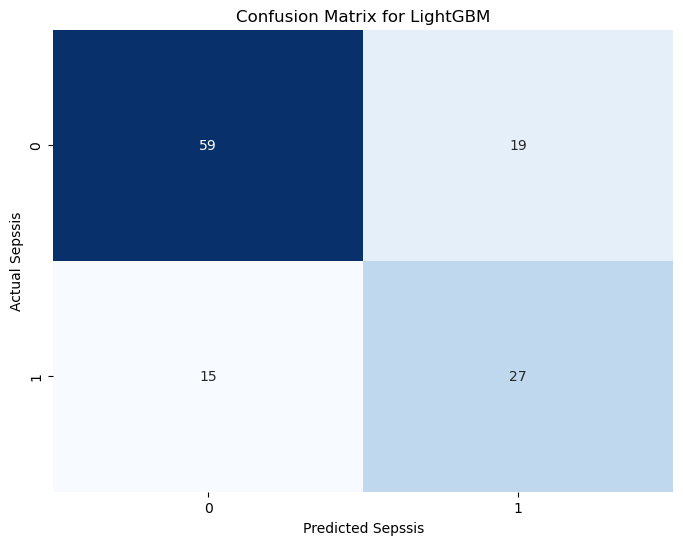

Confusion Matrix for LightGBM:
[[59 19]
 [15 27]]



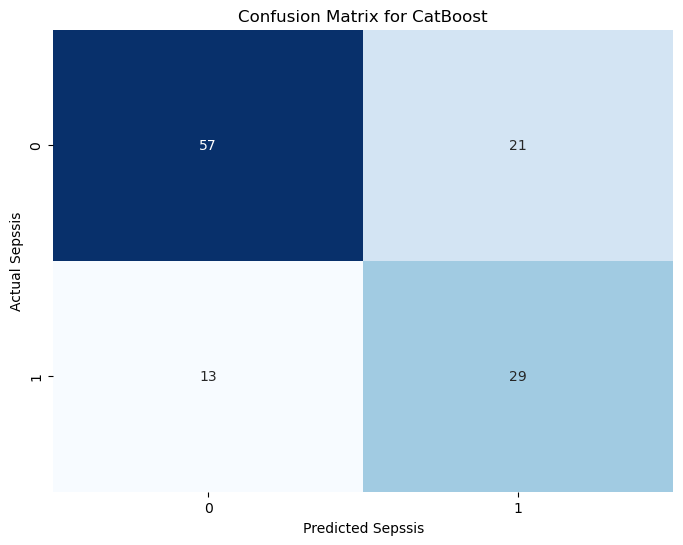

Confusion Matrix for CatBoost:
[[57 21]
 [13 29]]



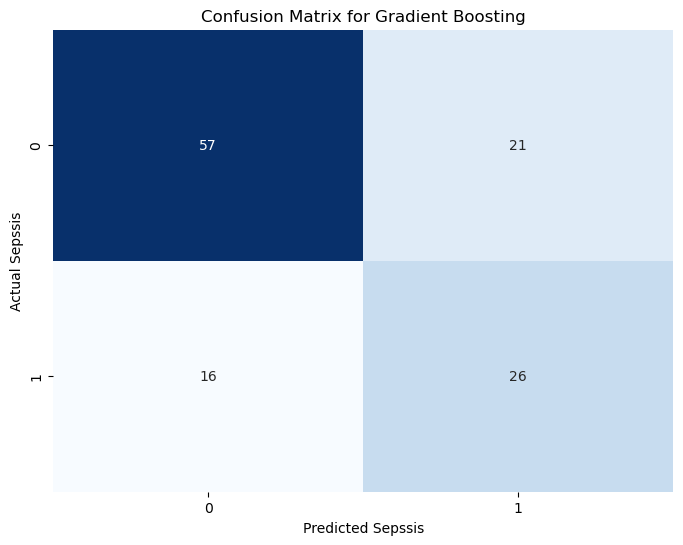

Confusion Matrix for Gradient Boosting:
[[57 21]
 [16 26]]



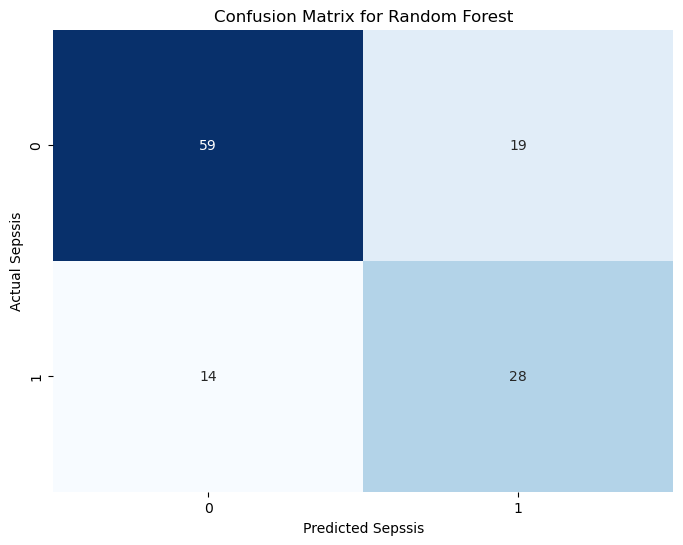

Confusion Matrix for Random Forest:
[[59 19]
 [14 28]]



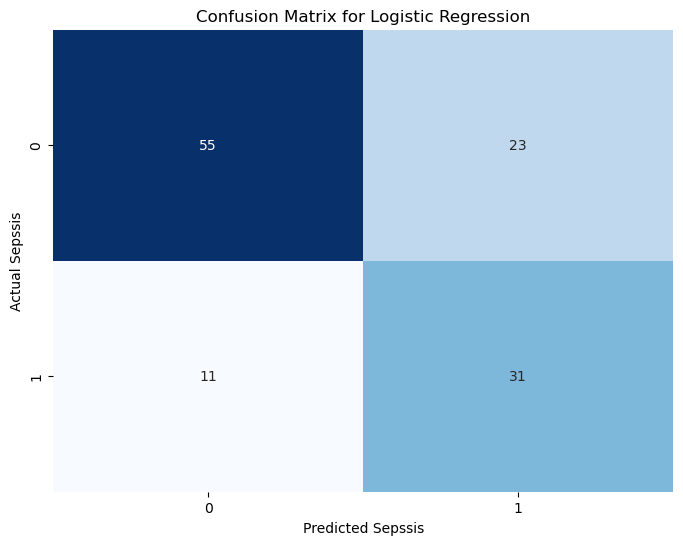

Confusion Matrix for Logistic Regression:
[[55 23]
 [11 31]]



In [65]:
for model, name in zip(models, model_names):
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_scaled)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Sepssis")
    plt.ylabel("Actual Sepssis")
    plt.show()
    
    print(f"Confusion Matrix for {name}:")
    print(cm)
    print()

The confusion matrix is a fundamental evaluation metric used in binary classification to understand how well a machine learning model is performing. It presents a clear breakdown of predictions made by the model. Let's break down the numbers in the confusion matrix you provided:

In our confusion matrix for the AdaBoost model:

- True Positive (TP): 33
  - This represents the number of instances where the model correctly predicted "Yes" (positive class) when the actual class was also "Yes."

- False Positive (FP): 19
  - This represents the number of instances where the model incorrectly predicted "Yes" when the actual class was "No."

- True Negative (TN): 59
  - This represents the number of instances where the model correctly predicted "No" (negative class) when the actual class was also "No."

- False Negative (FN): 9
  - This represents the number of instances where the model incorrectly predicted "No" when the actual class was "Yes."
  
  The confusion matrix for the AdaBoost model is typically interpreted as follows:

- True Positives (TP): 34 cases were correctly predicted as positive (sepsis) by the model.
- True Negatives (TN): 58 cases were correctly predicted as negative (not sepsis) by the model.
- False Positives (FP): 20 cases were incorrectly predicted as positive (sepsis) when they were actually negative (not sepsis).
- False Negatives (FN): 8 cases were incorrectly predicted as negative (not sepsis) when they were actually positive (sepsis).

## Hyperparameter Tuning

In [68]:
# Define a function for hyperparameter tuning specifically for AdaBoost
def tune_adaboost(X_train_balanced, y_train_balanced, X_test_scaled, y_test):
    param_grid = {
        'n_estimators': [800,1000,1200,1400,1600],
        'learning_rate': [0.1, 0.05, 0.01, 0.001]
    }

    ada_model = AdaBoostClassifier(random_state=4)
    grid_search = GridSearchCV(ada_model, param_grid, scoring='f1', cv=5, verbose=3, refit=True)
    grid_search.fit(X_train_balanced, y_train_balanced)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_pred = best_model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)

    return best_model, best_params, f1

# Perform hyperparameter tuning for AdaBoost
best_model, best_params, ada_f1 = tune_adaboost(X_train_balanced, y_train_balanced, X_test_scaled, y_test)

print("Best parameters for AdaBoost:", best_params)
print("Tuned F1-score for AdaBoost:", ada_f1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END learning_rate=0.1, n_estimators=800;, score=0.744 total time=   4.9s
[CV 2/5] END learning_rate=0.1, n_estimators=800;, score=0.639 total time=   4.7s
[CV 3/5] END learning_rate=0.1, n_estimators=800;, score=0.810 total time=   4.9s
[CV 4/5] END learning_rate=0.1, n_estimators=800;, score=0.842 total time=   4.6s
[CV 5/5] END learning_rate=0.1, n_estimators=800;, score=0.815 total time=   4.5s
[CV 1/5] END learning_rate=0.1, n_estimators=1000;, score=0.740 total time=   5.9s
[CV 2/5] END learning_rate=0.1, n_estimators=1000;, score=0.645 total time=   5.9s
[CV 3/5] END learning_rate=0.1, n_estimators=1000;, score=0.832 total time=   5.8s
[CV 4/5] END learning_rate=0.1, n_estimators=1000;, score=0.851 total time=   5.7s
[CV 5/5] END learning_rate=0.1, n_estimators=1000;, score=0.812 total time=   5.8s
[CV 1/5] END learning_rate=0.1, n_estimators=1200;, score=0.740 total time=   7.1s
[CV 2/5] END learning_rate=0.1

[CV 4/5] END learning_rate=0.001, n_estimators=1600;, score=0.746 total time=   9.1s
[CV 5/5] END learning_rate=0.001, n_estimators=1600;, score=0.815 total time=   9.2s
Best parameters for AdaBoost: {'learning_rate': 0.01, 'n_estimators': 1400}
Tuned F1-score for AdaBoost: 0.7083333333333334


In [69]:
print(best_model)

AdaBoostClassifier(learning_rate=0.01, n_estimators=1400, random_state=4)


* The Adaboost model maintained it performance after a series of hyperparameter tuning.

## Export Key Component

In [70]:
# Create a dictionary to store the exported variables
exported_data = {
    'numerical_imputer': numerical_imputer,
    'scaler': scaler,
    'best_model': best_model
}

In [71]:
# Create a folder to store the exported data
folder_name = 'exported_comp_folder'
os.makedirs(folder_name, exist_ok=True)

In [72]:
# Export the variables
exported_data_path = os.path.join(folder_name, 'sepssis_components.pkl')
with open(exported_data_path, 'wb') as file:
    pickle.dump(exported_data, file)

In [73]:
# Generate the requirements.txt file
!pip freeze > exported_comp_folder/requirements.txt

In [74]:
# Zip the exported_data folder
shutil.make_archive('exported_data', 'zip', 'exported_comp_folder')

print("Exported data has been zipped.")

Exported data has been zipped.


## Test Prediction

In [75]:
exported_data_path = 'exported_comp_folder/sepssis_components.pkl'
with open(exported_data_path, 'rb') as file:
    exported_data = pickle.load(file)

In [76]:
# categorical_imputer = exported_data['categorical_imputer']
numerical_imputer = exported_data['numerical_imputer']
# encoder = exported_data['encoder']
scaler = exported_data['scaler']
best_model = exported_data['best_model']

In [77]:
# Load the Raw Prediction Data
test_df = pd.read_csv('Asset\Paitients_Files_Test.csv')

In [78]:
test_df

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,ICU200609,1,109,38,18,120,23.1,0.407,26,1
1,ICU200610,1,108,88,19,0,27.1,0.400,24,1
2,ICU200611,6,96,0,0,0,23.7,0.190,28,1
3,ICU200612,1,124,74,36,0,27.8,0.100,30,1
4,ICU200613,7,150,78,29,126,35.2,0.692,54,0
...,...,...,...,...,...,...,...,...,...,...
164,ICU200773,10,101,76,48,180,32.9,0.171,63,1
165,ICU200774,2,122,70,27,0,36.8,0.340,27,1
166,ICU200775,5,121,72,23,112,26.2,0.245,30,1
167,ICU200776,1,126,60,0,0,30.1,0.349,47,1


In [79]:
ids = test_df['ID'].copy()

In [80]:
test_df.drop(['ID', 'Insurance'], axis=1, inplace=True)

In [81]:
test_df.dtypes

PRG      int64
PL       int64
PR       int64
SK       int64
TS       int64
M11    float64
BD2    float64
Age      int64
dtype: object

In [82]:
test_df

,PRG,PL,PR,SK,TS,M11,BD2,Age
0,1,109,38,18,120,23.1,0.407,26
1,1,108,88,19,0,27.1,0.400,24
2,6,96,0,0,0,23.7,0.190,28
3,1,124,74,36,0,27.8,0.100,30
4,7,150,78,29,126,35.2,0.692,54
...,...,...,...,...,...,...,...,...
164,10,101,76,48,180,32.9,0.171,63
165,2,122,70,27,0,36.8,0.340,27
166,5,121,72,23,112,26.2,0.245,30
167,1,126,60,0,0,30.1,0.349,47


In [83]:
# Preprocessing for numerical data
prediction_data_numerical = test_df.select_dtypes(include=['int', 'float'])

# Apply imputation to numerical data
prediction_data_numerical_imputed = numerical_imputer.transform(prediction_data_numerical)

# Apply scaling to numerical data
prediction_data_scaled = scaler.transform(prediction_data_numerical_imputed)

# Convert the scaled numerical data to a DataFrame
prediction_data_scaled_df = pd.DataFrame(prediction_data_scaled,
                                         columns=prediction_data_numerical.columns,
                                         index=prediction_data_numerical.index)

# Perform Predictions
predictions = best_model.predict(prediction_data_scaled_df)

# DataFrame for Predictions
prediction_results = pd.DataFrame({'ID': ids, 'Sepssis predictions': predictions})


In [84]:
# DataFrame for Predictions
prediction_results = pd.DataFrame({'ID': ids, 'Sepssis predictions': predictions})

In [85]:
# Map predictions to "Positive" and "Negative"
prediction_results['Sepssis predictions'] = prediction_results['Sepssis predictions'].map({1: 'Positive', 0: 'Negative'})

In [86]:
prediction_results

,ID,Sepssis predictions
0,ICU200609,Negative
1,ICU200610,Negative
2,ICU200611,Negative
3,ICU200612,Negative
4,ICU200613,Positive
...,...,...
164,ICU200773,Negative
165,ICU200774,Negative
166,ICU200775,Negative
167,ICU200776,Positive


In [87]:
# Count the occurrences of "Positive" and "Negative" in the predictions
count = prediction_results['Sepssis predictions'].value_counts()

# Print the count
print(count)

Negative    102
Positive     67
Name: Sepssis predictions, dtype: int64


In [ ]:
# Save the Predictions
prediction_results.to_csv('sepssis_prediction_results.csv', index=False)

Based on the distribution of predictions on the new unseen data:

- Negative Predictions: 94
- Positive Predictions: 75

It can be concluded that the model made predictions for both negative and positive cases of sepsis. The model identified 94 cases as negative (no sepsis) and 75 cases as positive (sepsis). which is a fairly good generalization of the model.

In [ ]:
df_train.dtypes